Demonstration of using Spiral from `spiral.py` to estimate multiple variables (though one works too) in a PTV framework.  This simulation uses a Poisson noise model, but others can be employed in this optimizer.  Some are already defined in `loss.py` and users can create their own using the framework defined in that file.

Processing with 

In [2]:
import sys,os
import torch
import numpy as np
import matplotlib.pyplot as plt
import yaml
import importlib
import datetime
from matplotlib.colors import LogNorm

import xarray as xr

In [3]:
# load file path information from the home directory
file_path_yml = os.path.join(os.environ["HOME"], ".ncar_config_derecho.yaml")
path_data = {}
with open(file_path_yml, "r") as r:
    path_data = yaml.safe_load(r)

In [4]:
dirP_str = os.path.join(
    path_data["ptv_collection_path"], "SpiralTorch", "python"
)
if dirP_str not in sys.path:
    sys.path.append(dirP_str)

In [5]:
from SpiralTorch import spiral
from SpiralTorch import loss

In [6]:
dirP_str = os.path.join(
    path_data['python_library_path'], "NCAR-LidarProcessing", "libraries"
)
if dirP_str not in sys.path:
    sys.path.append(dirP_str)

In [7]:
import xarray_utils.mpd_utils as mpd
# import xarray_utils.doe_arm_utils as arm
import xarray_utils.plot_utils as xplt

In [8]:
# use this block to autodetect if a GPU is available
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")
# device = torch.device("cpu")

if is_cuda:
    torch.backends.cudnn.benchmark = True

print(f'Preparing to use device {device}')

dtype = torch.float64

Preparing to use device cuda:0


In [119]:
path_data

{'software_path': '/glade/u/home/mhayman/Python/lidar-super-2021/python/library/data_utils',
 'python_library_path': '/glade/u/home/mhayman/Python/',
 'temperature_tmp_save_path': '/glade/derecho/scratch/mhayman/DIAL/tmp/',
 'save_data_path': '/glade/derecho/scratch/mhayman/MPD/cals/',
 'save_fig_path': '/glade/dereocho/scratch/mhayman/MPD/cals/Plots/',
 'cal_path': '/glade/u/home/mhayman/Python/eol-lidar-calvals/',
 'external_data_path': '/glade/derecho/scratch/mhayman/external_data/',
 'ptv_collection_path': '/glade/u/home/mhayman/Python/ptv_collection/',
 'mpd_data': {1: '/glade/derecho/scratch/mhayman/DIAL/tmp/raw_mpd_data/mpd_01_data/',
  2: '/glade/derecho/scratch/mhayman/DIAL/tmp/raw_mpd_data/mpd_02_data/',
  3: '/glade/derecho/scratch/mhayman/DIAL/tmp/raw_mpd_data/mpd_03_data/',
  4: '/glade/derecho/scratch/mhayman/DIAL/tmp/raw_mpd_data/mpd_04_data/',
  5: '/glade/derecho/scratch/mhayman/DIAL/tmp/raw_mpd_data/mpd_05_data/'},
 'cal_file': {1: '/glade/u/home/mhayman/Python/eol-li

# Load short/long pulse backscatter observations
MPD 4 ran in short/long pulse mode after May 1, 2024

Make sure to transfer data to servers
```
mpd_raw_data_copy.bash <MPD Number> <YYYYMMDD>
```

In [165]:
start_time = datetime.datetime(2024, 10, 23, 20)
stop_time = start_time + datetime.timedelta(hours=2)
MPDnumber = 4
time_resolution = 60 # 10
channel_request = ['WVOffline', 'WVOfflineLow','WVOnline', 'WVOnlineLow']
bg_start_index = -500
bg_stop_index = -100
random_time = True  # randomly thin the profiles (as opposed to alternating thinning)

range_min = 0.1e3
range_max = 6e3

In [166]:
MPDnumber

4

In [167]:
mcs_sets = mpd.load_dataset(start_time, stop_time,
                            MPDnumber, time_resolution, channel_request,
                            thin_num=2, random_thin = random_time,
                            basepath=path_data['mpd_data'][MPDnumber], cal_path=path_data['cal_path'],
                            deadtime_correct_raw=True,
                            afterpulse_correct=False,
                            verbose=False,
                            )
channel_list = mpd.list_var_type(mcs_sets[0],'LidarProfile')

ds_lst = []
bg_rate_lst = []
for ds in mcs_sets:
    mpd.copy_raw_data(ds)
    mpd.background_subtract(ds,index=bg_start_index,stop_index=bg_stop_index)  # not really used
    mpd.get_detector_active_time(ds)
    # TODO load approximate temperature and pressure
    mpd.add_approx_temperature_pressure(ds, lapse_rate=9.5)
    # TODO load absorption profiles
    mpd.add_narrow_freq_absorption(ds)
    
    bg_dct = {}
    for ch in channel_list:
        bg_dct[ch] = {}
        bg_dct[ch]['counts'] = np.sum(ds[ch+"_Uncorr"].values[:,bg_start_index:bg_stop_index],axis=1)
        bg_dct[ch]['active_time'] = np.sum(ds[ch+"_ActiveTime"].values[:,bg_start_index:bg_stop_index],axis=1)
        bg_dct[ch]['rate'] = bg_dct[ch]['counts']/bg_dct[ch]['active_time']
    bg_rate_lst.append(bg_dct)
    
    ds_lst.append(ds.sel(range=slice(range_min,range_max)))

No entry for Gas_Cell_Temperature found
No entry for Gas_Cell_Pressure found
No entry for Gas_Cell_Length found
No entry for Gas_Cell_Species found
No afterpulse calibration found for WVOfflineLow
No afterpulse calibration found for WVOnlineLow
No afterpulse calibration found for WVOfflineLow
No afterpulse calibration found for WVOnlineLow
points covered by weather station: 100.0 %


In [168]:
bg_total_dct = {}
for idx, bg_dct in enumerate(bg_rate_lst):
    for ch in bg_dct:
        if ch in bg_total_dct.keys():
            for var in bg_dct[ch]:
                bg_total_dct[ch][var] += bg_dct[ch][var]
        else:
            bg_total_dct[ch] = {}
            for var in bg_dct[ch]:
                bg_total_dct[ch][var] = bg_dct[ch][var].copy()

for ch in bg_total_dct:
    bg_total_dct[ch]['rate'] = bg_total_dct[ch]['counts']/bg_total_dct[ch]['active_time']

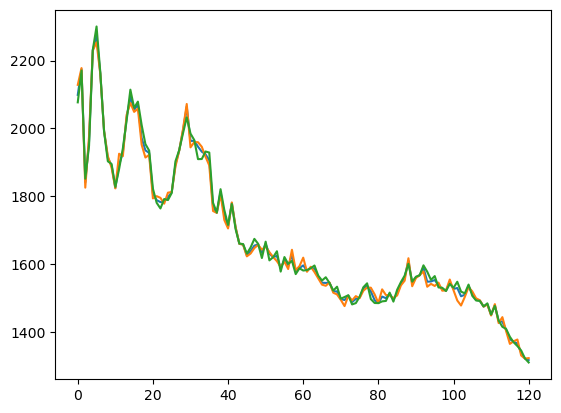

In [169]:
plt.figure()
plt.plot(bg_total_dct[ch]['rate'])
plt.plot(bg_rate_lst[0][ch]['rate'])
plt.plot(bg_rate_lst[1][ch]['rate'])

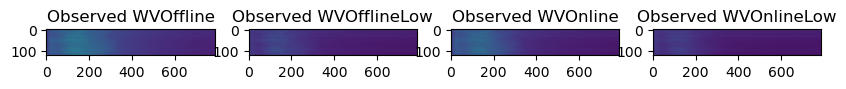

In [170]:
fig,ax_lst = plt.subplots(1, len(channel_list), figsize=(10,5))
for ch_idx, channel_str in enumerate(channel_list):
    if len(channel_list) == 1:
        ax = ax_lst
    else:
        ax = ax_lst[ch_idx]
    im = ax.imshow(ds_lst[0][channel_str+"_Uncorr"].values+ds_lst[1][channel_str+"_Uncorr"].values,norm=LogNorm())
    ax.set_title(f"Observed {channel_str}")
    if ch_idx == 0:
        clim = im.get_clim()
    else:
        im.set_clim(clim)

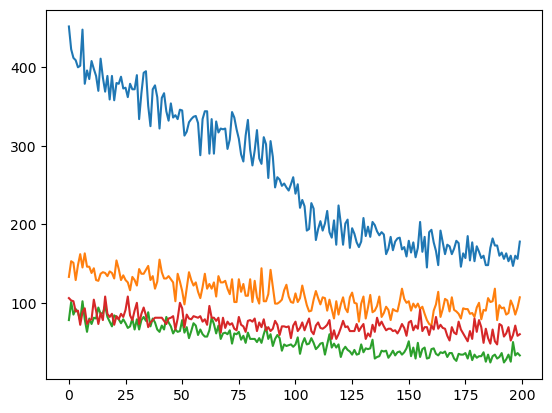

In [171]:
t_idx = 20
plt.figure()
for ch_idx, channel_str in enumerate(channel_list):
    plt.plot(ds_lst[0][channel_str+"_Uncorr"].values[t_idx,200:400])

In [172]:
ds_lst[0][channel_str+"_ActiveTime"]

<xarray.DataArray 'WVOnlineLow_ActiveTime' (time: 121, range: 788)> Size: 763kB
array([[0.01199933, 0.01199898, 0.01199905, ..., 0.01199938, 0.01199935,
        0.01199945],
       [0.03199757, 0.0319979 , 0.03199755, ..., 0.03199811, 0.03199868,
        0.03199854],
       [0.02399838, 0.02399829, 0.02399824, ..., 0.02399908, 0.02399917,
        0.02399894],
       ...,
       [0.02799813, 0.02799843, 0.02799801, ..., 0.02799919, 0.02799926,
        0.02799919],
       [0.02399852, 0.02399838, 0.02399827, ..., 0.0239994 , 0.02399921,
        0.02399924],
       [0.03199787, 0.03199799, 0.0319982 , ..., 0.03199878, 0.03199898,
        0.0319991 ]])
Coordinates:
  * time     (time) datetime64[ns] 968B 2024-10-23T20:00:00 ... 2024-10-23T22...
  * range    (range) float64 6kB 101.2 108.7 116.2 ... 5.985e+03 5.992e+03 6e+03
Attributes:
    units:            seconds
    description:      estimated detector active time in each bin.  Accounts f...
    time_resolution:  2.5e-07
    deadtime:         2.31e-08
    shot_counts:      WVOnlineLow_LaserShotCount

In [173]:
ds_lst[0]['range'].attrs['range_resolution']*2/mpd.c

5.0000000000000004e-08

Generate a scene of data similar to depolarization where one channel observes a parallel and perpendicular polarization term such that the mean photon flux in each channel is

$\alpha_1 = \beta(1-d/2)$

$\alpha_2 = \frac{1}{2}\beta d$

and the observations are 

$y_1 \sim Poisson(\alpha_1)$

$y_2 \sim Poisson(\alpha_2)$

In [174]:
ds['WVOffline_WV_absorption_crosssection']

<xarray.DataArray 'WVOffline_WV_absorption_crosssection' (time: 121, range: 2450)> Size: 2MB
array([[4.81319299e-29, 4.81048044e-29, 4.80776866e-29, ...,
        4.27970295e-30, 4.27093792e-30, 4.26218168e-30],
       [4.81310203e-29, 4.81038957e-29, 4.80767788e-29, ...,
        4.27990524e-30, 4.27114016e-30, 4.26238387e-30],
       [4.81275784e-29, 4.81004577e-29, 4.80733447e-29, ...,
        4.28121062e-30, 4.27244500e-30, 4.26368818e-30],
       ...,
       [4.79766176e-29, 4.79496473e-29, 4.79226847e-29, ...,
        4.32062171e-30, 4.31184504e-30, 4.30307708e-30],
       [4.79760080e-29, 4.79490375e-29, 4.79220747e-29, ...,
        4.32016231e-30, 4.31138601e-30, 4.30261843e-30],
       [4.79575884e-29, 4.79306578e-29, 4.79037349e-29, ...,
        4.36023227e-30, 4.35134884e-30, 4.34247408e-30]])
Coordinates:
  * time     (time) datetime64[ns] 968B 2024-10-23T20:00:00 ... 2024-10-23T22...
  * range    (range) float64 20kB -71.2 -63.71 -56.21 ... 1.828e+04 1.828e+04
Attributes:
    units:                m^2
    description:          Absorption cross section of water vapor for narrow ...
    classdef:             array
    ancillary_variables:

# Process Scene using Spiral TV with regularizer optimization

In [175]:
fista_ver_str = 'jit-fista'  # 'cuda-fista', 'jit-fista'
noise_model_str = 'deadtime_bg'

Set up a grid search to locate the optimal regularization for each estimated variable

In [176]:
tv_reg_dct = {
    # 'rho':np.array([1.0]),
    # 'nwv':np.array([5.0]),
    # 'rho':np.logspace(-0.5,0.5,4), # cloud secen 2024, 5, 7, 2
    # 'nwv':np.logspace(-4,-2,8), # cloud secen 2024, 5, 7, 2
    'rho':np.logspace(-0.5,0.5,4), # low altitude , 5, 7, 2
    'nwv':np.logspace(-1.8,-0.8,4), # low altitude , 5, 7, 2
}

In [177]:
# create regularizer grid
tv_lst = []
for var in tv_reg_dct:
    tv_lst.append(tv_reg_dct[var])

tv_mesh_tup = np.meshgrid(*tv_lst)

grid_count = tv_mesh_tup[0].size

In [178]:
# mpd.square_laser_pulse(2,0.4)[0][None,None,...].shape

In [179]:
# pulse_tnsr = torch.tensor(laser_pulse(2,0.34)[None,None,...],dtype=dtype,device=device)


In [180]:
# input_test = torch.randn(1, 1, 12, 43,dtype=dtype,device=device)
# input_test.shape

In [181]:
# output_test = torch.nn.functional.conv2d(input_test,pulse_tnsr,padding=(0,pulse_tnsr.shape[-1]-1)).squeeze()[:,:-(pulse_tnsr.shape[-1]-1)]

In [182]:
# output_test.shape

Define forward models for each observation channel

In [183]:
def laser_pulse(pulse_len,grid_res):
    pulse = np.ones(int(np.ceil(pulse_len/grid_res)))
    pulse[-1] = np.remainder(pulse_len,grid_res)/grid_res
    return pulse.reshape(1,-1)

class long_short_mpd:
    def __init__(self,range_time_resolution:float):
        self.dt = range_time_resolution  #set the time resolution in the range axis
        self.dr = mpd.c*self.dt/2
        self.pulse_lst = []
        self.pulse_length_lst = []
        self.pulse_pad_lst = []
        self.bg_lst = []
        self.abs_lst = []

        self.wv_mult = mpd.N_A/mpd.mH2O

    def set_pulse_lengths(self,pulse_length_lst):
        self.pulse_lst = []
        self.pulse_length_lst = []
        self.pulse_pad_lst = []
        
        for pulse_len in pulse_length_lst:
            self.pulse_length_lst.append(pulse_len)
            self.pulse_lst.append(torch.tensor(laser_pulse(pulse_len,self.dt)[None,None,...],dtype=dtype,device=device))
            self.pulse_pad_lst.append(self.pulse_lst[-1].shape[-1]-1)

    def set_absorption(self,absorption_lst):
        self.abs_lst = []
        for absorption in absorption_lst:
            self.abs_lst.append(torch.tensor(absorption,dtype=dtype,device=device))
            
    def set_backgrounds(self,bg_lst):
        self.bg_lst = []
        for bg in bg_lst:
            self.bg_lst.append(torch.tensor(bg.squeeze()[:,None],dtype=dtype,device=device))
    
    def fwd_model_ch(self,ch_idx,**x):
        rho0 = torch.exp(x['rho'])*torch.exp(-2*torch.cumsum(x['nwv']*self.abs_lst[ch_idx]*self.dr*self.wv_mult,dim=1))
        rho_ch = torch.nn.functional.conv2d(rho0[None,None,...],
                    self.pulse_lst[ch_idx],
                    padding=(0,(self.pulse_pad_lst[ch_idx]))).squeeze()[:,:-self.pulse_pad_lst[ch_idx]]+self.bg_lst[ch_idx]
        fwd_mod_ch = {
            'y_mean_est':rho_ch
        }
        return fwd_mod_ch

    def fwd_model_ch0(self,**x):
        return self.fwd_model_ch(0,**x)

    def fwd_model_ch1(self,**x):
        return self.fwd_model_ch(1,**x)

    def fwd_model_ch2(self,**x):
        return self.fwd_model_ch(2,**x)

    def fwd_model_ch3(self,**x):
        return self.fwd_model_ch(3,**x)


# class long_short_backscatter:
#     def __init__(self,range_time_resolution:float):
#         self.dt = range_time_resolution  #set the time resolution in the range axis
#         self.pulse_lst = []
#         self.pulse_length_lst = []
#         self.bg_lst = []

#     def set_pulse_lengths(self,pulse_length_lst):
#         for pulse_len in pulse_length_lst:
#             self.pulse_length_lst.append(pulse_len)
#             self.pulse_lst.append(torch.tensor(mpd.square_laser_pulse(pulse_len,self.dt,norm=False)[0][None,None,...],dtype=dtype,device=device))

#     def set_backgrounds(self,bg_lst):
#         for bg in bg_lst:
#             self.bg_lst.append(torch.tensor(bg.squeeze()[:,None],dtype=dtype,device=device))
    
#     def fwd_model_ch(self,ch_idx,**x):
#         rho0 = torch.exp(x['rho'])
#         rho_ch = torch.nn.functional.conv2d(rho0[None,None,...],
#                     self.pulse_lst[ch_idx],
#                     padding=(0,(self.pulse_lst[ch_idx].shape[-1]-1)//2)).squeeze()+self.bg_lst[ch_idx]
#         fwd_mod_ch = {
#             'y_mean_est':rho_ch
#         }
#         return fwd_mod_ch

#     def fwd_model_ch0(self,**x):
#         return self.fwd_model_ch(0,**x)

#     def fwd_model_ch1(self,**x):
#         return self.fwd_model_ch(1,**x)

In [184]:
mpd_model = long_short_mpd(ds_lst[0]['range'].attrs['range_resolution']*2/mpd.c)

pulse_length_lst = []
for ch in channel_list:
    if 'Low' in ch:
        pulse_length_lst.append(0.2e-6)
    else:
        pulse_length_lst.append(1e-6)

mpd_model.set_pulse_lengths(pulse_length_lst)

bg_lst = []
for ch in bg_total_dct:
    if 'bg' in noise_model_str:
        bg_lst.append(np.zeros(bg_total_dct[ch]['rate'].shape))
    else:
        bg_lst.append(bg_total_dct[ch]['rate'])
    

mpd_model.set_backgrounds(bg_lst)

In [185]:
absorption_lst = []
for idx, ch_str in enumerate(channel_list):
    absorption_lst.append(ds_lst[0][ch_str+"_WV_absorption_crosssection"].values)

mpd_model.set_absorption(absorption_lst)

Set the foward model list and load the observations to correspond with the forward models.  Observations should consist of statistically independent `fit` (for optimization) and `validation` (for optimizing the TV regularization) data.

In [186]:
# setup mask for convolution where pulse does not have full overlap in worst case
max_idx = 0
for pulse in mpd_model.pulse_lst:
    max_idx = np.maximum(max_idx,pulse.shape[-1])

In [187]:
fwd_model_lst = [
    mpd_model.fwd_model_ch0,
    mpd_model.fwd_model_ch1,
    mpd_model.fwd_model_ch2,
    mpd_model.fwd_model_ch3,
]

y_fit_dct_lst = []
y_val_dct_lst = []

for idx, ch_str in enumerate(channel_list):
    ch_mask = np.ones(ds_lst[0][ch_str+"_Uncorr"].values.shape)
    ch_mask[:,:max_idx] = 0
    ch_mask[:,-max_idx:] = 0
    fit_dct = {'counts': ds_lst[0][ch_str+"_Uncorr"].values,
                          'active_time': ds_lst[0][ch_str+"_ActiveTime"].values,
                          'channel_mask': ch_mask,}
    val_dct = {'counts': ds_lst[1][ch_str+"_Uncorr"].values,
                          'active_time': ds_lst[1][ch_str+"_ActiveTime"].values,
                          'channel_mask': ch_mask,}
    if 'bg' in noise_model_str:
        fit_dct['bg'] = bg_rate_lst[0][ch_str]['rate'][:,np.newaxis]
        val_dct['bg'] = bg_rate_lst[1][ch_str]['rate'][:,np.newaxis]
    y_fit_dct_lst.append(fit_dct)
    y_val_dct_lst.append(val_dct)



In [188]:
# create spiral optimization object
spiral_opt = spiral.multiSpiral_autograd(device,dtype,max_iterations=1500)  # these terms were set in the cell used to autodetect a GPU
spiral_opt.set_fista_version(fista_ver_str)  # set the FISTA version ('jit-fista' by default)
spiral_opt.set_fwd_model_lst(fwd_model_lst)  # load the forward models into the optimizer
spiral_opt.set_y_fit_lst(y_fit_dct_lst)   # load the fit data into the optimizer
spiral_opt.set_y_val_lst(y_val_dct_lst)   # load the validation data into the optimizer
spiral_opt.set_noise_model([noise_model_str,noise_model_str,noise_model_str,noise_model_str])  # set the noise model to be used for each channel (they don't have to be the same)

In [189]:
# check for alignment between observations and the noise model inputs
pass_test_bool, out_text, = spiral_opt.check_noise_model_inputs()
print(f"check passed: {pass_test_bool}")
print(out_text)

check passed: True
fit data is does not have a dictionary entry for optional input channel_weight in channel 0
validation data is does not have a dictionary entry for optional input channel_weight in channel 0
fit data is does not have a dictionary entry for optional input channel_weight in channel 1
validation data is does not have a dictionary entry for optional input channel_weight in channel 1
fit data is does not have a dictionary entry for optional input channel_weight in channel 2
validation data is does not have a dictionary entry for optional input channel_weight in channel 2
fit data is does not have a dictionary entry for optional input channel_weight in channel 3
validation data is does not have a dictionary entry for optional input channel_weight in channel 3



In [190]:
sparsa_subprob_config_dct = {
    'rho':{
        'alpha_min':1e4,
        'alpha_max':1e20,
        'alpha':1,
    },
    'nwv':{
        'alpha_min':1e4,
        'alpha_max':1e20,
        'alpha':1,
    },
    }

In [191]:
# set the initial conditions
x0 = {
    'rho':np.zeros(ds_lst[0][ch_str+"_Uncorr"].values.shape)+np.log(10),
    'nwv':np.zeros(ds_lst[0][ch_str+"_Uncorr"].values.shape)+1.0,
}

In [192]:
# set the variables to be estimated (and order in which they are optimizers)
spiral_opt.set_estimate_lst(['rho','nwv'])

# this is where the subproblems for each variable get created, so there needs to be an entry for each
spiral_opt.add_sparsa_config(sparsa_subprob_config_dct)
spiral_opt.set_initial_conditions(x0)
# spiral_opt.set_tv_penalties({'beta':1e0,'d':1e1})  # this must happen after the subproblem is defined
spiral_opt.verbose = False

Run the spiral optimizer over the regularizer search space.  Store the Validation NLL for each outcome

In [ ]:
x_sol_lst = []
vld_loss_lst = []
opt_time_lst = []
loss_iter = []
valid_loss_iter = []
step_size_iter = []

for idx in range(grid_count):
    tv_dct = {}
    for var_idx, var in enumerate(tv_reg_dct):
        tv_dct[var] = tv_mesh_tup[var_idx].flatten()[idx]
        print(var+f": {tv_mesh_tup[var_idx].flatten()[idx]}")
    spiral_opt.set_tv_penalties(tv_dct)  # this must happen after the subproblem is defined
    
    # reinitialize
    # spiral_opt.set_alpha(1.0)
    spiral_opt.set_initial_conditions(x0)
    
    # optimize
    term_str = spiral_opt.solve()

    # store result
    x_sol = spiral_opt.get_x()
    x_sol_lst.append(x_sol)
    vld_loss = spiral_opt.valid_loss()  # this is used for TV regularization optimization
    vld_loss_lst.append(vld_loss)
    opt_time_lst.append(spiral_opt.stop_time - spiral_opt.start_time)
    # store the optimization loss curves
    loss_iter.append(np.array(spiral_opt.loss_lst))
    valid_loss_iter.append(np.array(spiral_opt.valid_loss_lst))
    step_size_iter.append(np.array(spiral_opt.step_size_lst))

    print(term_str)
    print(f"validation loss: {vld_loss}")
    print(f"optimization time: {opt_time_lst[-1]} seconds")
    if np.argmin(vld_loss_lst) == idx:
        print("New validation minimum")
    print()

rho: 0.31622776601683794
nwv: 0.015848931924611134
Average validation loss increased over last 10 iterations
validation loss: -358476420.17007065
optimization time: 452.5189399719238 seconds
New validation minimum

rho: 0.6812920690579612
nwv: 0.015848931924611134
Average validation loss increased over last 10 iterations
validation loss: -358481805.13619226
optimization time: 565.0534374713898 seconds
New validation minimum

rho: 1.4677992676220695
nwv: 0.015848931924611134
Average validation loss increased over last 10 iterations
validation loss: -358484202.69395
optimization time: 484.99045181274414 seconds
New validation minimum

rho: 3.162277660168379
nwv: 0.015848931924611134
Exceeded maximum of 1500 iterations
validation loss: -358482997.45440745
optimization time: 891.8779826164246 seconds

rho: 0.31622776601683794
nwv: 0.034145488738336005
Average validation loss increased over last 10 iterations
validation loss: -358477028.9920802
optimization time: 517.7192413806915 seconds



In [ ]:
plt_idx = np.argmin(vld_loss_lst)
fig,ax = plt.subplots(2,1,figsize=(6,5))
ax[0].plot(loss_iter[plt_idx])
ax[0].plot(valid_loss_iter[plt_idx])
ax[1].plot(np.diff(loss_iter[plt_idx]))
ax[1].plot(np.diff(valid_loss_iter[plt_idx]))

fig,ax = plt.subplots(1,1,figsize=(5,3))
ax.plot(step_size_iter[plt_idx])
ax.set_yscale('log')


In [ ]:
np.where(np.diff(valid_loss_iter[plt_idx])>0)

In [ ]:
# np.diff(valid_loss_iter[plt_idx])

Locate the best solution then display the results

In [ ]:
sol_idx = np.argmin(vld_loss_lst)
x_sol = x_sol_lst[sol_idx]

In [ ]:
# # plot the regularizer search space
# # the lowest validation NLL is the best TV regularization

# for 2 or more regularizers, select which variables to plot (by index)
var_idx_x = 0
var_idx_y = 1

if len(tv_reg_dct.keys()) == 1:
    var_idx_x = 0
    tv_var_x = list(tv_reg_dct.keys())[var_idx_x]
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    im = ax.scatter(tv_mesh_tup[var_idx_x].flatten(),vld_loss_lst,c=opt_time_lst)
    ax.set_xlabel(tv_var_x + " Regularizer")
    ax.set_xscale('log')
    ax.grid(visible=True)
    plt.colorbar(im,ax=ax,label="optimization time [seconds]")
else:
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    tv_var_x = list(tv_reg_dct.keys())[var_idx_x]
    tv_var_y = list(tv_reg_dct.keys())[var_idx_y]
    
    im = ax.scatter(tv_mesh_tup[var_idx_x].flatten(),tv_mesh_tup[var_idx_y].flatten(),c=vld_loss_lst)
    ax.plot(tv_mesh_tup[var_idx_x].flatten()[sol_idx],tv_mesh_tup[var_idx_y].flatten()[sol_idx],'wx')
    ax.set_xlabel(tv_var_x + " Regularizer")
    ax.set_ylabel(tv_var_y + " Regularizer")
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(visible=True)
    plt.colorbar(im,ax=ax,label="validation NLL")

In [ ]:
# plot the optimal solution and actual data (from the simulation) for comparison
plt_x_dct = {
    'rho':{'function':np.exp,
           'label':r'$\rho$',
           'units':'Hz',
           'scale':'log',
           'description':'PTV Estimated backscatter flux from scene'},
    'nwv':{
           'label':r'$n_{wv}$',
           'units':'$g/m^3$',
           'scale':'linear',
           'description':'PTV Estimated absolute humidity from scene'},
}
clim_dct = {}

# fig,ax_lst = plt.subplots(1,len(x_act.keys()),figsize=(10,5))
# for var_idx, var in enumerate(x_act_test):
#     if len(x_act.keys()) == 1:
#         ax = ax_lst
#     else:
#         ax = ax_lst[var_idx]
#     im = ax[var_idx].imshow(x_act_test[var])
#     ax[var_idx].set_title(f"Actual "+plt_x_dct[var]['label'])
#     clim_dct[var] = im.get_clim()
#     plt.colorbar(im,ax=ax[var_idx])
    

fig,ax_lst = plt.subplots(1,len(x_sol.keys()),figsize=(10,5))
for var_idx, var in enumerate(x_sol):
    plot_kwargs ={}
    
    if len(x_sol.keys()) == 1:
        ax = ax_lst
    else:
        ax = ax_lst[var_idx]
        
    if 'function' in plt_x_dct[var]:
        plot_arr = plt_x_dct[var]['function'](x_sol[var])
    else:
        plot_arr = x_sol[var]
    if plt_x_dct[var].get('scale','linear') == 'log':
        plot_kwargs['norm'] = LogNorm()
        
        
    im = ax.imshow(plot_arr,**plot_kwargs)
    ax.set_title(f"Estimated "+plt_x_dct[var]['label'])
    # im.set_clim(clim_dct[var])
    plt.colorbar(im,ax=ax)

In [ ]:
# calculate the forward model of the solution for each observation channel
fwd_model_dct_lst = []

x_sol_tnsr = {}

for var in x_sol:
    x_sol_tnsr[var] = spiral_opt.to_tensor(x_sol[var])

for idx, model in enumerate(spiral_opt.fwd_model_lst):
    y_est = model(**x_sol_tnsr)
    fwd_dct = {}
    for var in y_est:
        fwd_dct[var] = y_est[var].detach().cpu()
    fwd_model_dct_lst.append(fwd_dct)

In [ ]:
output_ds = xr.Dataset({'time':ds_lst[0]['time'],'range':ds_lst[0]['range']})

In [ ]:
for var in plt_x_dct:
    if 'function' in plt_x_dct[var]:
        plot_arr = plt_x_dct[var]['function'](x_sol[var])
    else:
        plot_arr = x_sol[var]
    output_ds[var] = xr.DataArray(plot_arr,dims=('time','range'),
                            coords={'time':output_ds['time'],'range':output_ds['range']},
                            attrs={'units':plt_x_dct[var].get('units','None'),
                                'description':plt_x_dct[var].get('description','None')})

for idx, y_fit in enumerate(y_fit_dct_lst):
    for var in fwd_model_dct_lst[idx]:
        output_ds[f"fwd_model_ch{idx}_"+var] = xr.DataArray(fwd_model_dct_lst[idx][var],dims=('time','range',),
                                                        coords={'time':output_ds['time'],'range':output_ds['range']},
                                                        attrs={'units':"Hz",
                                                            'description':"Forward model of "+var+f" for channel {idx}, "+channel_list[idx],
                                                            'channel_name':channel_list[idx]})

    for var in y_fit_dct_lst[idx]:
        # TODO handle single dimension variables
        var_dim = ()
        var_coords = {}
        if y_fit_dct_lst[idx][var].shape[0] > 1:
            var_dim += ('time',)
            var_coords['time'] = output_ds['time']
        if y_fit_dct_lst[idx][var].shape[1] > 1:
            var_dim += ('range',)
            var_coords['range'] = output_ds['range']
        
        output_ds[f"fit_ch{idx}_"+var] = xr.DataArray(y_fit_dct_lst[idx][var].squeeze(),dims=var_dim,
                                                    coords=var_coords,
                                                    attrs={'units':"counts",
                                                        'description':"Observed fit "+var+f" photon data for channel {idx}, "+channel_list[idx],
                                                        'channel_name':channel_list[idx]})
    for var in y_val_dct_lst[idx]:
        # TODO handle single dimension variables
        var_dim = ()
        var_coords = {}
        if y_val_dct_lst[idx][var].shape[0] > 1:
            var_dim += ('time',)
            var_coords['time'] = output_ds['time']
        if y_val_dct_lst[idx][var].shape[1] > 1:
            var_dim += ('range',)
            var_coords['range'] = output_ds['range']
        
        output_ds[f"val_ch{idx}_"+var] = xr.DataArray(y_val_dct_lst[idx][var].squeeze(),dims=var_dim,coords=var_coords,
                                                    attrs={'units':"counts",
                                                        'description':"Observed validation "+var+f" photon data for channel {idx}, "+channel_list[idx],
                                                        'channel_name':channel_list[idx]})

    for var in y_val_dct_lst[idx]:
        # TODO handle single dimension variables
        var_dim = ()
        var_coords = {}
        if y_fit_dct_lst[idx][var].shape[0] > 1:
            var_dim += ('time',)
            var_coords['time'] = output_ds['time']
        if y_fit_dct_lst[idx][var].shape[1] > 1:
            var_dim += ('range',)
            var_coords['range'] = output_ds['range']
        output_ds[f"total_ch{idx}_"+var] = xr.DataArray(y_val_dct_lst[idx][var].squeeze()+y_fit_dct_lst[idx][var].squeeze(),dims=var_dim,coords=var_coords,
                                                    attrs={'units':"counts",
                                                        'description':"Observed total "+var+f" photon data for channel {idx}, "+channel_list[idx],
                                                        'channel_name':channel_list[idx]})

In [163]:
y_fit_dct_lst[idx][var].shape

(121, 1)

<Axes: title={'center': 'Wednesday October 23, 2024 total ch1 counts'}, xlabel='Time [h-UTC]', ylabel='Altitude AGL [km]'>

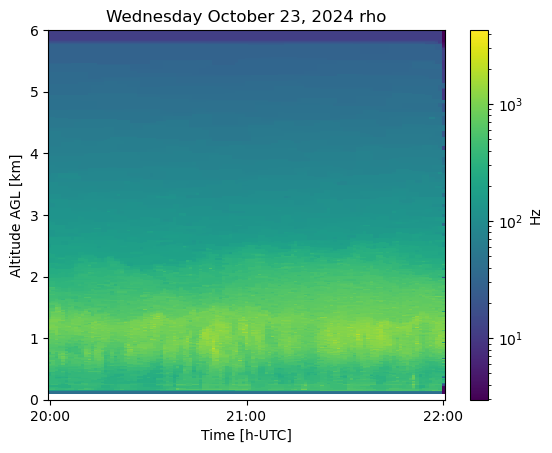

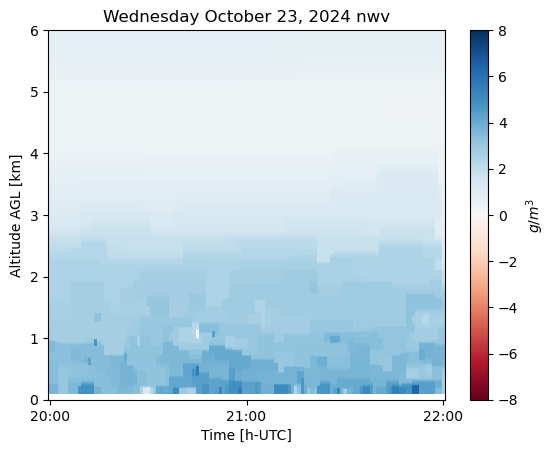

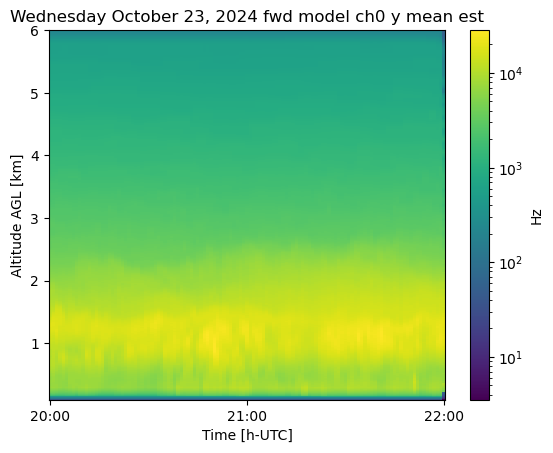

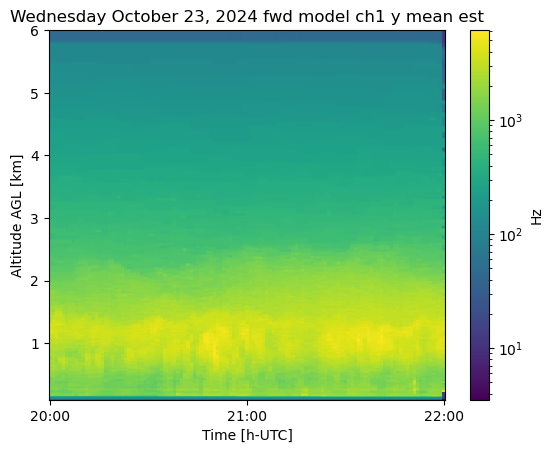

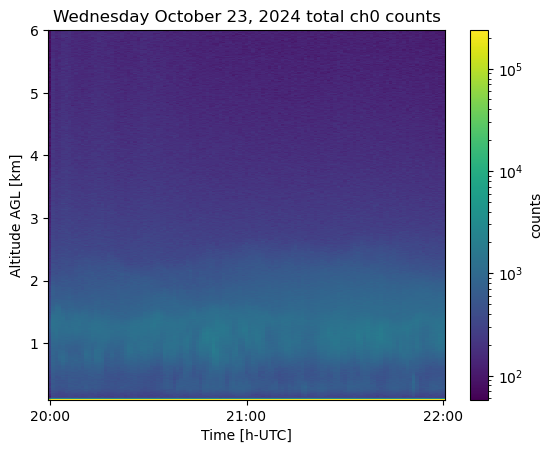

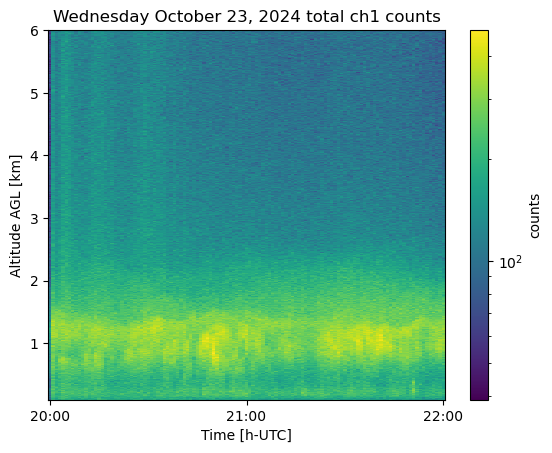

In [164]:
xplt.pcolor(output_ds,'rho',scale='log',ylim=[0,6])
xplt.pcolor(output_ds,'nwv',scale='linear',cmap='RdBu',clim=[-8,8],ylim=[0,6])

xplt.pcolor(output_ds,'fwd_model_ch0_y_mean_est',scale='log')
xplt.pcolor(output_ds,'fwd_model_ch1_y_mean_est',scale='log')

xplt.pcolor(output_ds,'total_ch0_counts',scale='log')
xplt.pcolor(output_ds,'total_ch1_counts',scale='log')

In [109]:
int(range_min*1e-3)

0

In [110]:
filename = f"mpd{MPDnumber:02}."+start_time.strftime("%Y%m%dT%H%M%S.")+stop_time.strftime("%Y%m%dT%H%M%S.")+f"WV.{int(range_min*1e-3)}km,{int(range_max*1e-3)}km.PTVdeconvolve."+noise_model_str+".nc"


In [111]:
filename

'mpd04.20241023T200000.20241023T220000.WV.0km,6km.PTVdeconvolve.deadtime_bg.nc'

In [112]:
os.path.join('/glade/derecho/scratch/mhayman/temp',filename)

'/glade/derecho/scratch/mhayman/temp/mpd04.20241023T200000.20241023T220000.WV.0km,6km.PTVdeconvolve.deadtime_bg.nc'

In [113]:
output_ds.to_netcdf(os.path.join('/glade/derecho/scratch/mhayman/temp',filename))

mcs_sets[0].to_netcdf(os.path.join('/glade/derecho/scratch/mhayman/temp',filename.replace(".nc",".raw_fit.nc")))
mcs_sets[1].to_netcdf(os.path.join('/glade/derecho/scratch/mhayman/temp',filename.replace(".nc",".raw_valid.nc")))

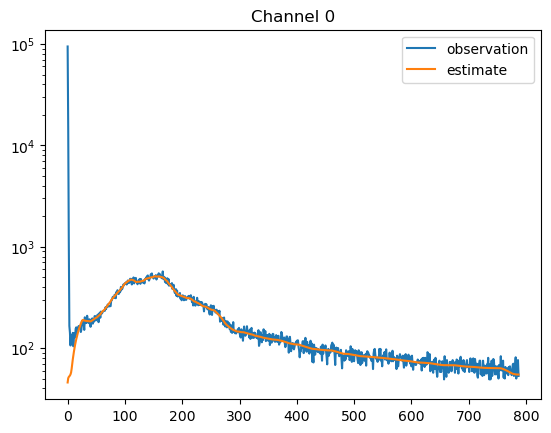

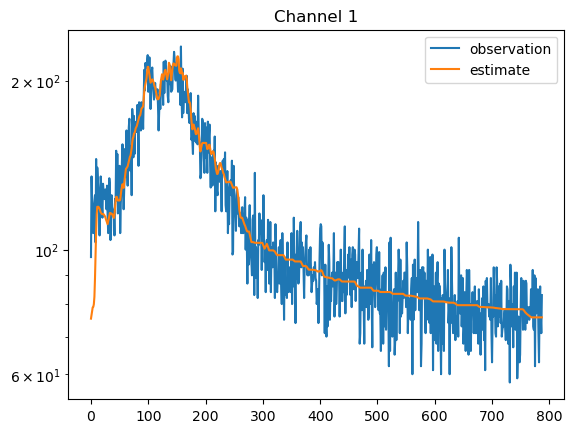

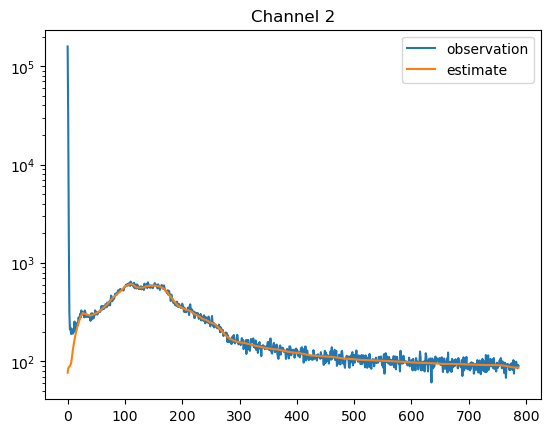

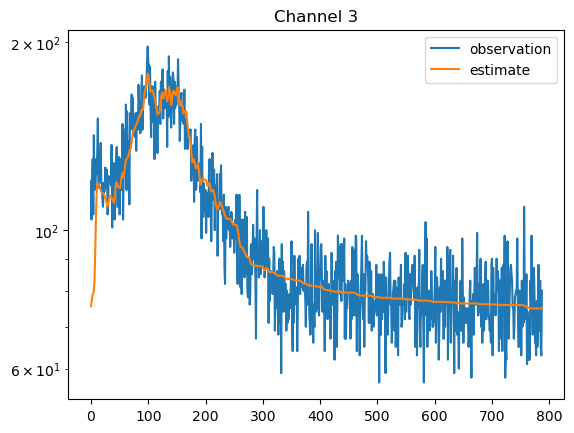

In [114]:
# plot a cross section of the forward model
obs_var = 'counts'
fwd_mod_var = 'y_mean_est'
time_idx = 29

for idx, fwd_mod in enumerate(fwd_model_dct_lst):
    if 'bg' in y_fit_dct_lst[idx].keys():
        bg = y_fit_dct_lst[idx]['bg'][time_idx,0]
    plt.figure()
    plt.plot(y_fit_dct_lst[idx][obs_var][time_idx,:],label='observation')
    # plt.plot(alpha_arr_lst[idx][time_idx,:],label='actual')
    plt.plot(torch.tensor(y_fit_dct_lst[idx]['active_time'][time_idx,:],dtype=dtype)*(fwd_mod[fwd_mod_var][time_idx,:]+bg),label='estimate')
    plt.legend()
    plt.title(f"Channel {idx}")
    plt.yscale('log')

In [115]:
y_fit_dct_lst[idx]['active_time']

array([[0.01599868, 0.01599884, 0.01599875, ..., 0.01599919, 0.01599903,
        0.01599915],
       [0.03199732, 0.03199774, 0.03199739, ..., 0.03199818, 0.03199875,
        0.03199831],
       [0.04399681, 0.04399688, 0.04399684, ..., 0.04399829, 0.04399792,
        0.04399778],
       ...,
       [0.0199985 , 0.01999831, 0.01999878, ..., 0.01999954, 0.01999945,
        0.01999947],
       [0.02399848, 0.02399829, 0.0239982 , ..., 0.02399935, 0.02399919,
        0.02399924],
       [0.02799836, 0.02799827, 0.02799848, ..., 0.02799887, 0.02799882,
        0.02799915]])

In [116]:
output_ds

<xarray.Dataset> Size: 32MB
Dimensions:                   (time: 121, range: 788)
Coordinates:
  * time                      (time) datetime64[ns] 968B 2024-10-23T20:00:00 ...
  * range                     (range) float64 6kB 101.2 108.7 ... 6e+03
Data variables: (12/54)
    rho                       (time, range) float64 763kB 33.02 33.02 ... 3.072
    nwv                       (time, range) float64 763kB 4.582 4.582 ... -0.138
    fwd_model_ch0_y_mean_est  (time, range) float64 763kB 33.02 66.03 ... 60.36
    fit_ch0_counts            (time, range) float64 763kB 6.344e+04 ... 26.0
    fit_ch0_active_time       (time, range) float64 763kB 0.01453 ... 0.02
    fit_ch0_channel_mask      (time, range) float64 763kB 0.0 0.0 ... 0.0 0.0
    ...                        ...
    val_ch3_channel_mask      (time, range) float64 763kB 0.0 0.0 ... 0.0 0.0
    val_ch3_bg                (time) float64 968B 2.115e+03 ... 1.313e+03
    total_ch3_counts          (time, range) float64 763kB 87.0 94.0 ... 83.0
    total_ch3_active_time     (time, range) float64 763kB 0.028 0.028 ... 0.06
    total_ch3_channel_mask    (time, range) float64 763kB 0.0 0.0 ... 0.0 0.0
    total_ch3_bg              (time) float64 968B 4.202e+03 ... 2.634e+03

In [117]:
!ls /glade/derecho/scratch/mhayman/temp/mpd04*.nc

/glade/derecho/scratch/mhayman/temp/mpd04.20240507T020000.20240507T040000.PTVdeconvolve.nc
/glade/derecho/scratch/mhayman/temp/mpd04.20240507T020000.20240507T040000.WV.0km,6km.PTVdeconvolve.nc
/glade/derecho/scratch/mhayman/temp/mpd04.20240507T020000.20240507T040000.WV.5km,12km.PTVdeconvolve.nc
/glade/derecho/scratch/mhayman/temp/mpd04.20240507T020000.20240507T040000.WV.PTVdeconvolve.nc
/glade/derecho/scratch/mhayman/temp/mpd04.20241023T200000.20241023T220000.WV.0km,6km.PTVdeconvolve.deadtime_bg.nc
/glade/derecho/scratch/mhayman/temp/mpd04.20241023T200000.20241023T220000.WV.0km,6km.PTVdeconvolve.deadtime_bg.raw_fit.nc
/glade/derecho/scratch/mhayman/temp/mpd04.20241023T200000.20241023T220000.WV.0km,6km.PTVdeconvolve.deadtime_bg.raw_valid.nc
/glade/derecho/scratch/mhayman/temp/mpd04.20241023T200000.20241023T220000.WV.0km,6km.PTVdeconvolve.nc
/glade/derecho/scratch/mhayman/temp/mpd04.20241023T200000.20241023T220000.WV.0km,6km.PTVdeconvolve.raw_fit.nc
/glade/derecho/scratch/mhayman/temp/mp

In [118]:
!rsync -avh -e ssh /glade/derecho/scratch/mhayman/temp/mpd04*.nc mhayman@gurgle.eol.ucar.edu:/scr/sci/mhayman/DIAL/deconvolve/examples/

Access to and use of this UCAR computer system is limited to
authorized use by UCAR Policies 1-7 and 3-6 and all applicable federal
laws, executive orders, policies and directives.  UCAR computer
systems are subject to monitoring at all times to ensure proper
functioning of equipment and systems including security devices, to
prevent unauthorized use and violations of statutes and security
regulations, to deter criminal activity, and for other similar
purposes. Users should be aware that information placed in the system
is subject to monitoring and is not subject to any expectation of
privacy.  Unauthorized use or abuse will be dealt with according to
UCAR Policy, up to and including criminal or civil penalties as
warranted. By logging in, you are agreeing to these terms.
sending incremental file list
mpd04.20241023T200000.20241023T220000.WV.0km,6km.PTVdeconvolve.deadtime_bg.nc
mpd04.20241023T200000.20241023T220000.WV.0km,6km.PTVdeconvolve.deadtime_bg.raw_fit.nc
mpd04.20241023T200000.2

In [ ]:
/glade/derecho/scratch/mhayman/temp/mpd04* mhayman@gurgle.eol.ucar.edu:/scr/sci/mhayman/DIAL/deconvolve/examples

In [270]:
!scp /glade/derecho/scratch/mhayman/temp/mpd04.20240507T020000.20240507T040000.PTVdeconvolve.nc mhayman@tikal.eol.ucar.edu:/scr/sci/mhayman/

Access to and use of this UCAR computer system is limited to
authorized use by UCAR Policies 1-7 and 3-6 and all applicable federal
laws, executive orders, policies and directives.  UCAR computer
systems are subject to monitoring at all times to ensure proper
functioning of equipment and systems including security devices, to
prevent unauthorized use and violations of statutes and security
regulations, to deter criminal activity, and for other similar
purposes. Users should be aware that information placed in the system
is subject to monitoring and is not subject to any expectation of
privacy.  Unauthorized use or abuse will be dealt with according to
UCAR Policy, up to and including criminal or civil penalties as
warranted. By logging in, you are agreeing to these terms.
mpd04.20240507T020000.20240507T040000.PTVdeco 100%  108MB 117.1MB/s   00:00    
